In [ ]:
! pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
import io
import pandas as pd
import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
from random import choices
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.inspection import permutation_importance
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving salary.csv to salary.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['salary.csv']))
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df['salary'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
features = df.loc[:, df.columns != 'salary'].columns
classes = df['salary'].unique()

In [ ]:
for i in features:
  print(i)
  print(df[i].unique())

age
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
fnlwgt
[ 77516  83311 215646 ...  34066  84661 257302]
education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
education-num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
marital-status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-o

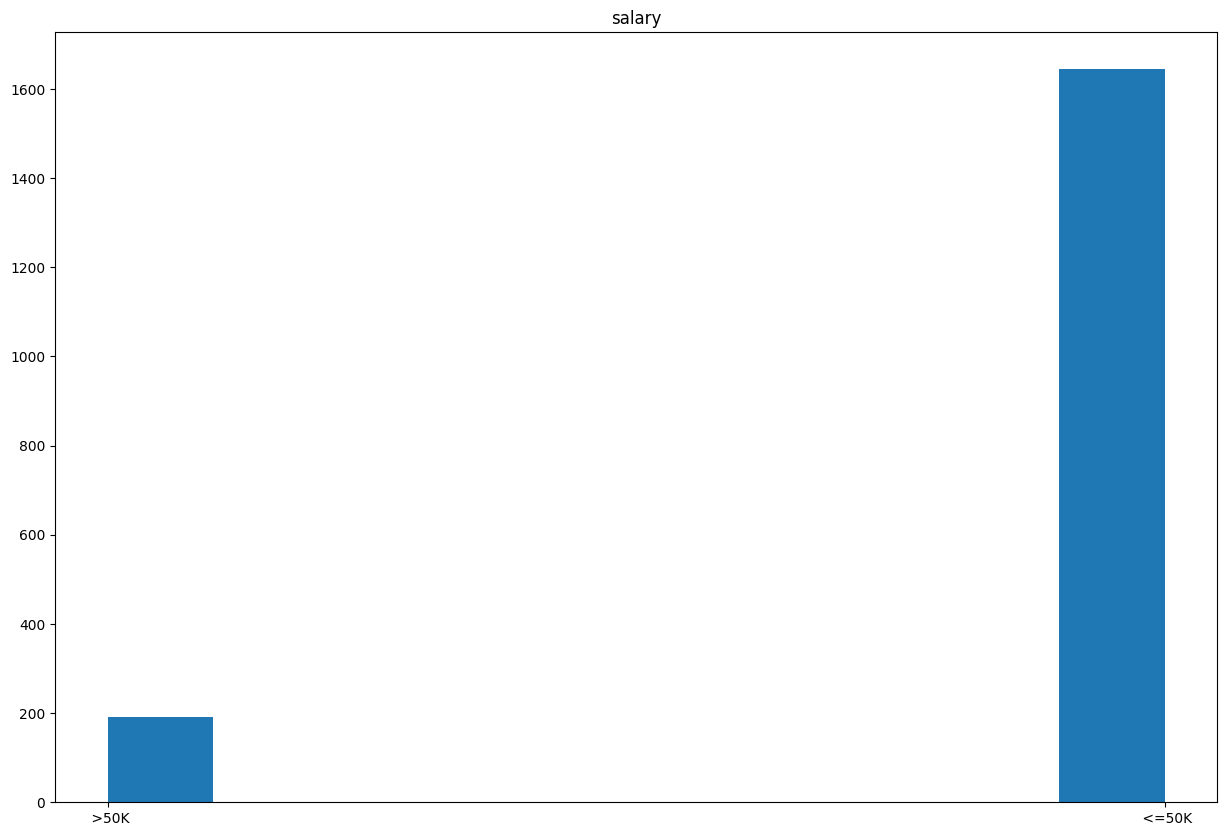

0.05638647461687295

In [ ]:
null_workclass = df[df['workclass'] == ' ?']
plt.hist(null_workclass['salary'])
plt.title('salary')
plt.show()
len(null_workclass)/len(df)

In [ ]:
# remove rows with ? value
for i in features:
  df = df.loc[df[i] != ' ?']

In [ ]:
len(df)

30162

In [ ]:
# One Hot Encoding
race_encoder=ce.OneHotEncoder(cols='race',return_df=True,use_cat_names=True)
sex_encoder=ce.OneHotEncoder(cols='sex',return_df=True,use_cat_names=True)
relationship_encoder=ce.OneHotEncoder(cols='relationship',return_df=True,use_cat_names=True)
workclass_encoder=ce.OneHotEncoder(cols='workclass',return_df=True,use_cat_names=True)
marital_status_encoder=ce.OneHotEncoder(cols='marital-status',return_df=True,use_cat_names=True)
df = race_encoder.fit_transform(df)
df = sex_encoder.fit_transform(df)
df = relationship_encoder.fit_transform(df)
df = workclass_encoder.fit_transform(df)
df = marital_status_encoder.fit_transform(df)

# Ordinal Encoding
'''
[{'col': 'occupation',
  'mapping':
   Adm-clerical          1
   Exec-managerial       2
   Handlers-cleaners     3
   Prof-specialty        4
   Other-service         5
   Sales                 6
   Transport-moving      7
   Farming-fishing       8
   Machine-op-inspct     9
   Tech-support         10
   Craft-repair         11
   Protective-serv      12
   Armed-Forces         13
   Priv-house-serv      14
  NaN                   -2
  dtype: int64, 'data_type': dtype('O')}]
'''
occupation_encoder = ce.OrdinalEncoder(cols='occupation', return_df=True)
df = occupation_encoder.fit_transform(df)

'''
[{'col': 'native-country',
  'mapping':
   United-States                  1
   Cuba                           2
   Jamaica                        3
   India                          4
   Mexico                         5
   Puerto-Rico                    6
   Honduras                       7
   England                        8
   Canada                         9
   Germany                       10
   Iran                          11
   Philippines                   12
   Poland                        13
   Columbia                      14
   Cambodia                      15
   Thailand                      16
   Ecuador                       17
   Laos                          18
   Taiwan                        19
   Haiti                         20
   Portugal                      21
   Dominican-Republic            22
   El-Salvador                   23
   France                        24
   Guatemala                     25
   Italy                         26
   China                         27
   South                         28
   Japan                         29
   Yugoslavia                    30
   Peru                          31
   Outlying-US(Guam-USVI-etc)    32
   Scotland                      33
   Trinadad&Tobago               34
   Greece                        35
   Nicaragua                     36
   Vietnam                       37
   Hong                          38
   Ireland                       39
   Hungary                       40
   Holand-Netherlands            41
  NaN                            -2
  dtype: int64, 'data_type': dtype('O')}]
'''
native_country_encoder = ce.OrdinalEncoder(cols='native-country', return_df=True)
df = native_country_encoder.fit_transform(df)

'''
[{'col': 'salary',
  'mapping':
   <=50K    1
   >50K     2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')}]
'''
salary_encoder = ce.OrdinalEncoder(cols='salary', return_df=True)
df = salary_encoder.fit_transform(df)

# drop column
df = df.drop(columns=['education', 'fnlwgt'])
df.head()

,age,workclass_ State-gov,workclass_ Self-emp-not-inc,workclass_ Private,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Self-emp-inc,workclass_ Without-pay,education-num,marital-status_ Never-married,...,race_ Asian-Pac-Islander,race_ Amer-Indian-Eskimo,race_ Other,sex_ Male,sex_ Female,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,1,0,0,0,0,0,0,13,1,...,0,0,0,1,0,2174,0,40,1,1
1,50,0,1,0,0,0,0,0,13,0,...,0,0,0,1,0,0,0,13,1,1
2,38,0,0,1,0,0,0,0,9,0,...,0,0,0,1,0,0,0,40,1,1
3,53,0,0,1,0,0,0,0,7,0,...,0,0,0,1,0,0,0,40,1,1
4,28,0,0,1,0,0,0,0,13,0,...,0,0,0,0,1,0,0,40,2,1


In [ ]:
df['salary'] = df['salary']-1
df['salary'].unique()

array([0, 1])

In [ ]:
df.info()
orig_df = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   age                                    30162 non-null  int64
 1   workclass_ State-gov                   30162 non-null  int64
 2   workclass_ Self-emp-not-inc            30162 non-null  int64
 3   workclass_ Private                     30162 non-null  int64
 4   workclass_ Federal-gov                 30162 non-null  int64
 5   workclass_ Local-gov                   30162 non-null  int64
 6   workclass_ Self-emp-inc                30162 non-null  int64
 7   workclass_ Without-pay                 30162 non-null  int64
 8   education-num                          30162 non-null  int64
 9   marital-status_ Never-married          30162 non-null  int64
 10  marital-status_ Married-civ-spouse     30162 non-null  int64
 11  marital-status_ Divorced    

In [ ]:
df_X = df[df.columns.drop("salary")].to_numpy()
df_y = df["salary"].to_numpy()
# split train and test
train, test = train_test_split(
    df,
    train_size=.8,
    random_state = 441,
    shuffle = True
)

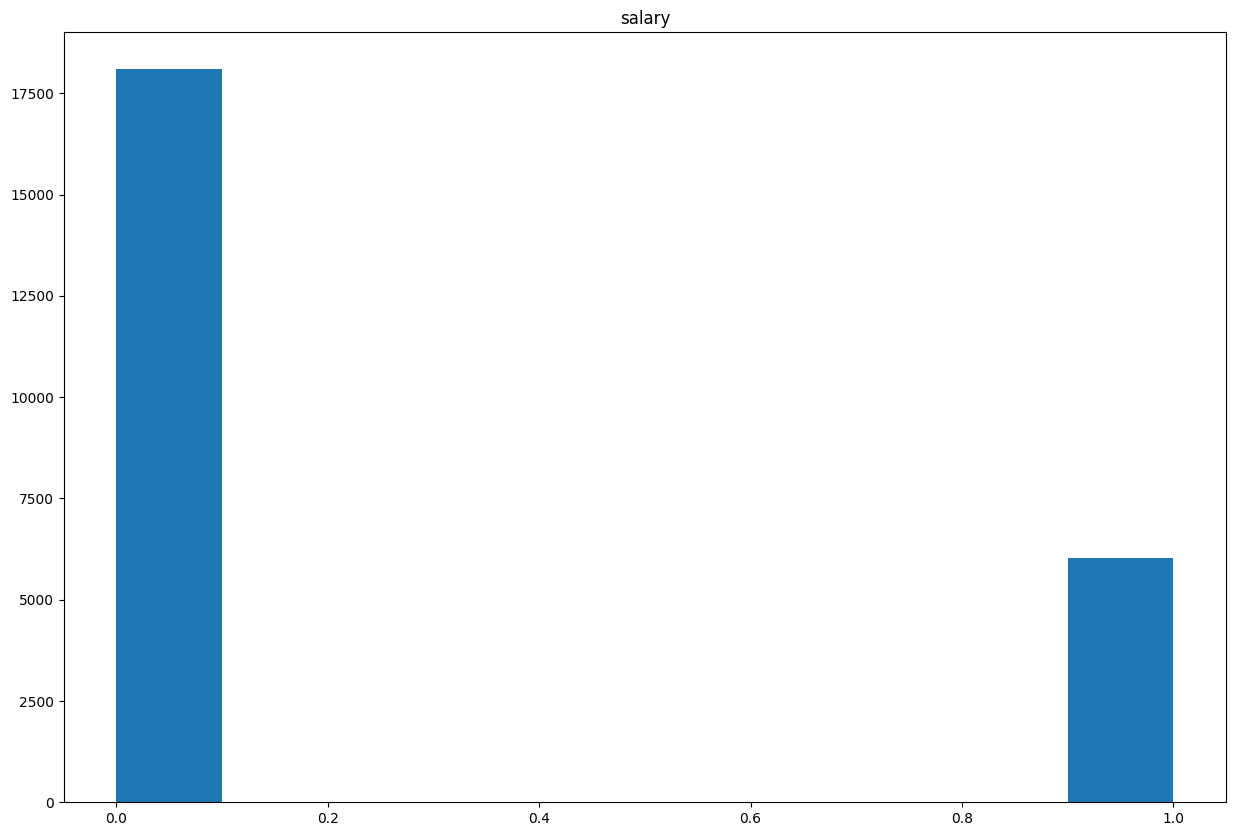

In [ ]:
# imbalance train data
plt.hist(train['salary'])
plt.title('salary')
plt.show()

In [ ]:
len(train[train['salary'] == 0])/len(train)

0.7502590244104604

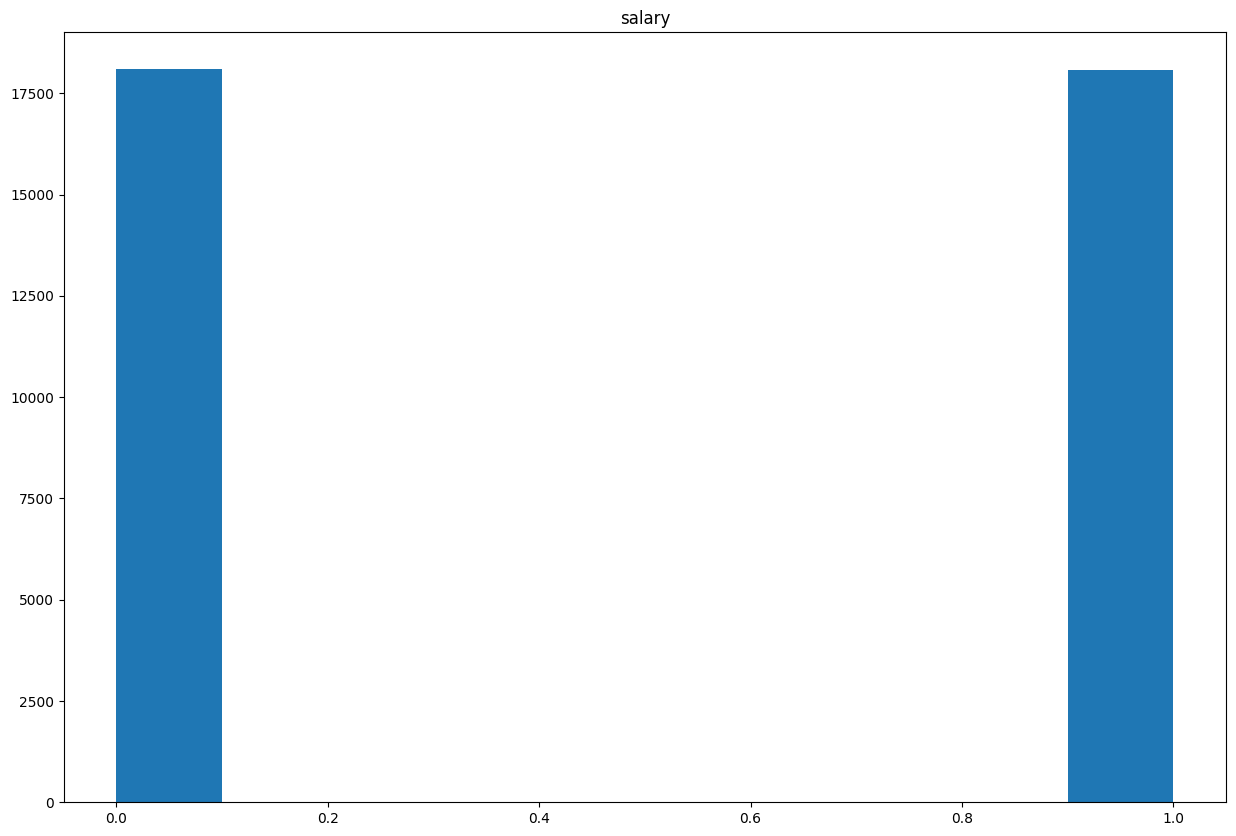

In [ ]:
# Sampling with Replacement
resampled = train[train['salary'] == 1].sample(frac=3, replace=True, random_state=1)
train = pd.concat([train[train['salary'] == 0], resampled])
plt.hist(train.loc[:, 'salary'])
plt.title('salary')
plt.show()

In [ ]:
for i in train.columns:
  print(i)
  print(train[i].unique())

age
[32 18 23 17 24 20 37 21 60 42 26 56 40 28 38 45 19 51 62 30 58 54 25 35
 43 31 61 36 22 53 49 39 27 47 29 67 52 50 34 33 41 46 70 55 59 69 71 48
 73 57 64 68 44 72 65 79 81 66 63 74 78 90 75 80 76 77 84 82 83 85 88 86]
workclass_ State-gov
[0 1]
workclass_ Self-emp-not-inc
[0 1]
workclass_ Private
[1 0]
workclass_ Federal-gov
[0 1]
workclass_ Local-gov
[0 1]
workclass_ Self-emp-inc
[0 1]
workclass_ Without-pay
[0 1]
education-num
[ 5 10  7  9 13  2 11 15  6  8 12  4 16 14  3  1]
marital-status_ Never-married
[0 1]
marital-status_ Married-civ-spouse
[1 0]
marital-status_ Divorced
[0 1]
marital-status_ Married-spouse-absent
[0 1]
marital-status_ Separated
[0 1]
marital-status_ Married-AF-spouse
[0 1]
marital-status_ Widowed
[0 1]
occupation
[ 7  5  1  9  6 10  8 11  2  4  3 12 14 13]
relationship_ Not-in-family
[0 1]
relationship_ Husband
[1 0]
relationship_ Wife
[0 1]
relationship_ Own-child
[0 1]
relationship_ Unmarried
[0 1]
relationship_ Other-relative
[0 1]
race_ White
[1 0]
ra

In [ ]:
# split features and labels into X and y
X_train = train[train.columns.drop("salary")].to_numpy()
y_train = train['salary'].to_numpy()
X_test = test[test.columns.drop("salary")].to_numpy()
y_test = test['salary'].to_numpy()
features = train[train.columns.drop("salary")].columns.unique()

In [ ]:
# for knn
features = orig_df[orig_df.columns.drop("salary")].columns.unique()
orig_df_X= orig_df[orig_df.columns.drop("salary")].to_numpy()
orig_df_Y = orig_df["salary"].to_numpy()
# split data into training and test sets
orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(
    orig_df_X,
    orig_df_Y,
    train_size=.8,
    random_state = 441,
    shuffle = True
)

# SVM

In [ ]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  svm.SVC())
])
param_grid = [
  #{'model__C': [0.1, 1, 10], 'model__kernel': ['linear']},
  {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf']},
    {'model__C': [0.1, 1, 10], 'model__degree': [2, 3], 'model__kernel': ['poly']},
    {'model__C': [0.1, 1, 10], 'model__kernel': ['sigmoid']}
 ]
cv = KFold(
    n_splits=5,  # number of folds
    shuffle=True # protects against data being ordered, e.g., all successes first
)

cv_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv
)

cv_model.fit(X=X_train, y=y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [0.1, 1, 10],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['rbf']},
                         {'model__C': [0.1, 1, 10], 'model__degree': [2, 3],
                          'model__kernel': ['poly']},
                         {'model__C': [0.1, 1, 10],
                          'model__kernel': ['sigmoid']}])

In [ ]:
mean_sc = cv_model.cv_results_['mean_test_score']

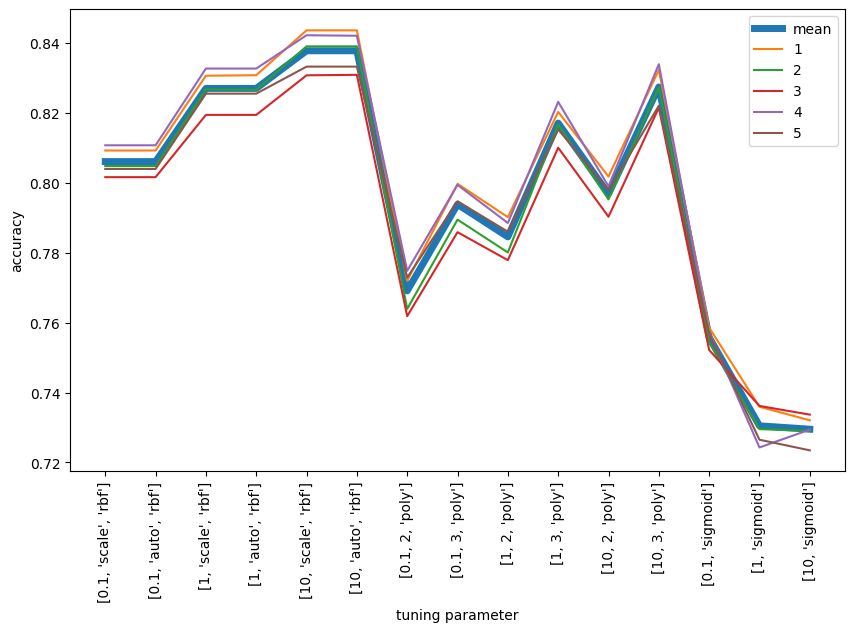

In [ ]:
# the higher the score, the less the loss
figure(figsize=(10,6))
x = range(len(mean_sc))
x_axis = [list(d.values()) for d in cv_model.cv_results_['params']]
plt.xticks(x, x_axis,rotation = 90)
plt.plot(x, mean_sc,label = "mean",linewidth = 5)
plt.plot(x, cv_model.cv_results_['split0_test_score'],label = "1")
plt.plot(x, cv_model.cv_results_['split1_test_score'],label = "2")
plt.plot(x, cv_model.cv_results_['split2_test_score'],label = "3")
plt.plot(x, cv_model.cv_results_['split3_test_score'],label = "4")
plt.plot(x, cv_model.cv_results_['split4_test_score'],label = "5")
plt.xlabel('tuning parameter')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
cv_model.best_params_

{'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}

In [ ]:
# test error
1.0 - cv_model.score(X=X_test, y=y_test)

0.21531576330183988

True negative rate(specificity):  0.7644473742034718
True positive rate(sensitivity):  0.8468286099865048
F1 score:  0.6589656077710685
Accuracy:  0.7846842366981601


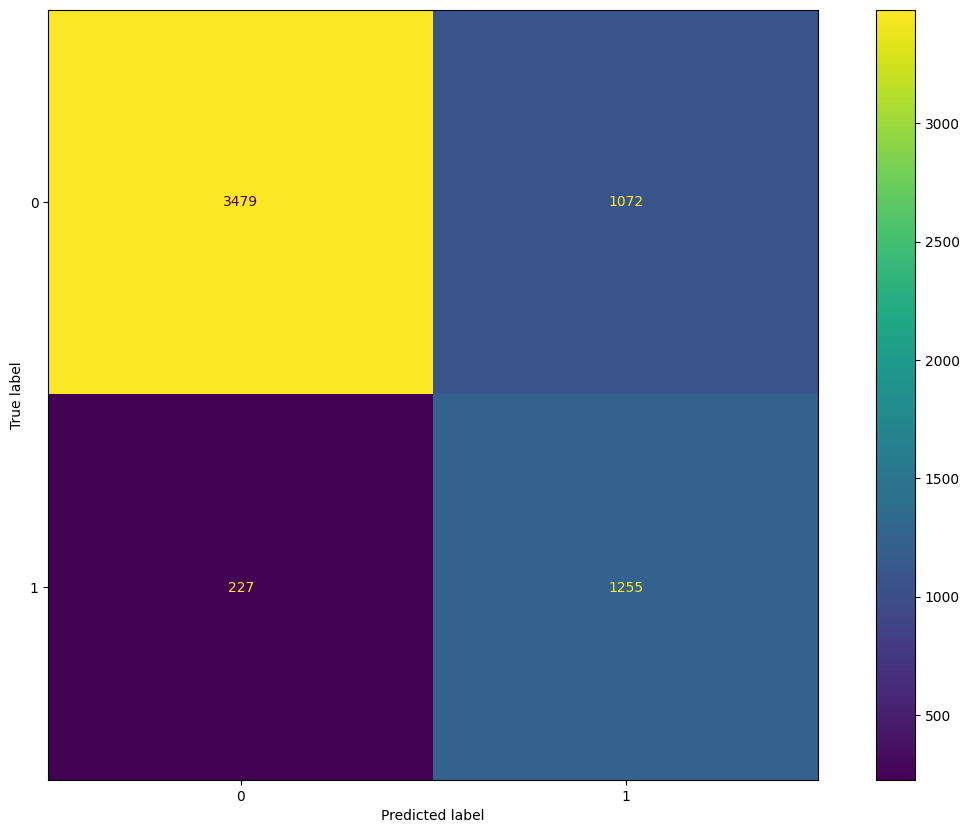

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=cv_model,
    X=X_test,
    y=y_test
)
tn, fp, fn, tp = confusion_matrix(y_test, cv_model.predict(X_test)).ravel()
print('True negative rate(specificity): ', tn / (tn + fp)) #true negative rate(specificity)
print('True positive rate(sensitivity): ', tp / (tp + fn)) #true positive rate(sensitivity)
print('F1 score: ',(2*tp)/(2*tp + fp + fn)) #f1 score
print('Accuracy: ',(tp + tn) / (tn + fp + fn + tp))

In [ ]:
perm_importance = permutation_importance(cv_model, X_test, y_test)

Text(0.5, 0, 'Feature Importance')

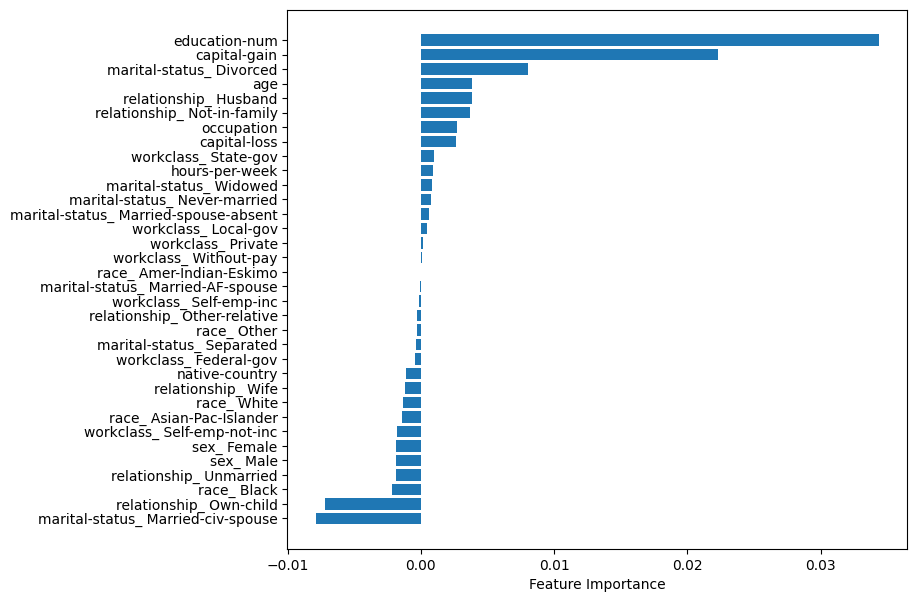

In [ ]:
feature_names = [train.drop(columns=['salary']).columns]
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8,7))
plt.barh(features[0][sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

Text(0.5, 0, 'Feature Importance')

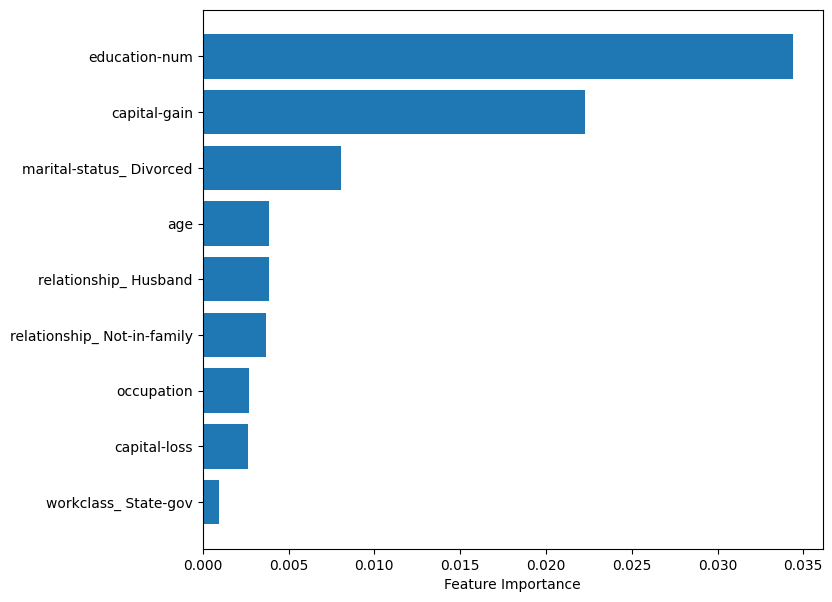

In [ ]:
plt.figure(figsize=(8,7))
plt.barh(features[0][sorted_idx[25:35]], perm_importance.importances_mean[sorted_idx[25:35]])
plt.xlabel("Feature Importance")

# Decision Tree

In [ ]:
tree_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  tree.DecisionTreeClassifier())
])
tree_param_grid = [
  {'model__criterion': ['gini', 'entropy'], 'model__min_samples_leaf': [100, 500],
   'model__max_depth': [5, 10], 'model__min_samples_split': [100, 500],
   'model__max_features': [None, 'sqrt']}
 ]
cv = KFold(
    n_splits=5,  # number of folds
    shuffle=True # protects against data being ordered, e.g., all successes first
)

tree_cv_model = GridSearchCV(
    estimator=tree_model,
    param_grid=tree_param_grid,
    cv=cv
)

tree_cv_model.fit(X=X_train, y=y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             param_grid=[{'model__criterion': ['gini', 'entropy'],
                          'model__max_depth': [5, 10],
                          'model__max_features': [None, 'sqrt'],
                          'model__min_samples_leaf': [100, 500],
                          'model__min_samples_split': [100, 500]}])

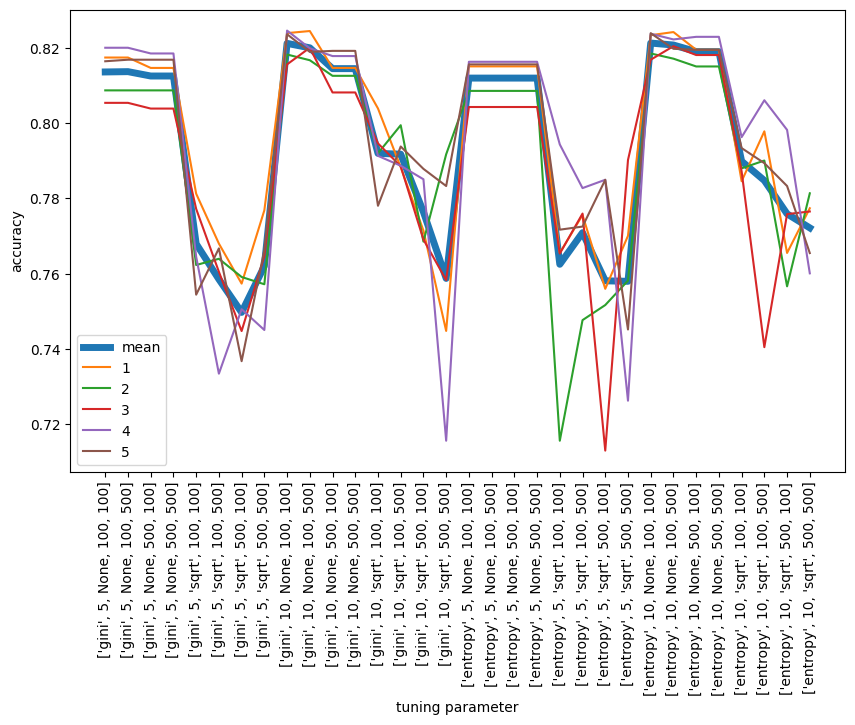

In [ ]:
tree_mean_sc = tree_cv_model.cv_results_['mean_test_score']

figure(figsize=(10,6))
x = range(len(tree_mean_sc))
x_axis = [list(d.values()) for d in tree_cv_model.cv_results_['params']]
plt.xticks(x, x_axis,rotation = 90)
plt.plot(x, tree_mean_sc,label = "mean",linewidth = 5)
plt.plot(x, tree_cv_model.cv_results_['split0_test_score'],label = "1")
plt.plot(x, tree_cv_model.cv_results_['split1_test_score'],label = "2")
plt.plot(x, tree_cv_model.cv_results_['split2_test_score'],label = "3")
plt.plot(x, tree_cv_model.cv_results_['split3_test_score'],label = "4")
plt.plot(x, tree_cv_model.cv_results_['split4_test_score'],label = "5")
plt.xlabel('tuning parameter')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We can see that certain models predict better than the rest.

In [ ]:
tree_cv_model.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 10,
 'model__max_features': None,
 'model__min_samples_leaf': 100,
 'model__min_samples_split': 100}

In [ ]:
# test error
1.0 - tree_cv_model.score(X=X_test, y=y_test)

0.20851980772418366

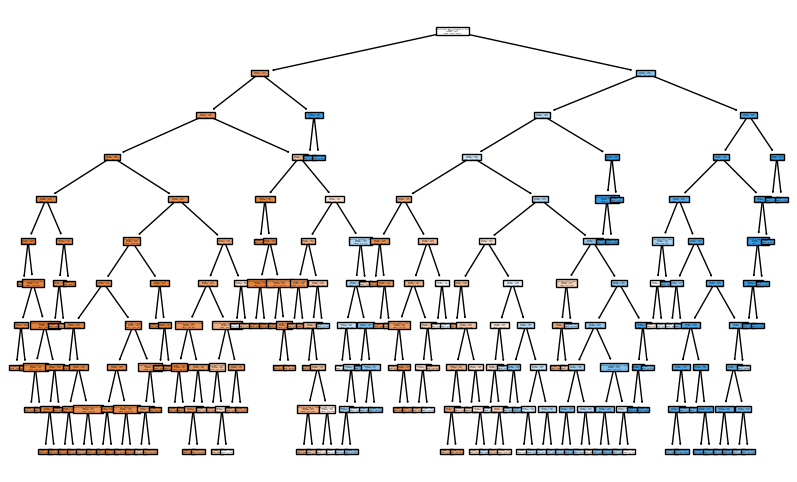

In [ ]:
figure(figsize=(10,6))
tree.plot_tree(tree_cv_model.best_estimator_.named_steps['model'],
               filled=True, feature_names=train.columns)
plt.show()

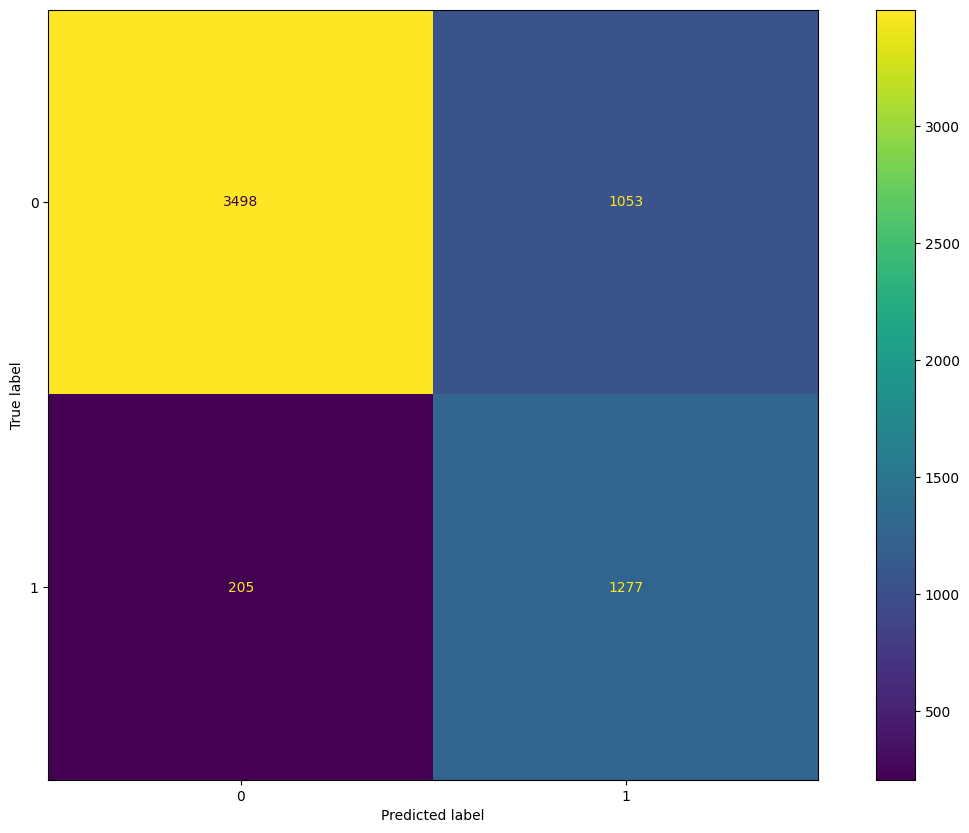

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=tree_cv_model,
    X=X_test,
    y=y_test
)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, tree_cv_model.best_estimator_.predict(X_test)).ravel()
tnr = tn / (tn + fp) #true negative rate(specificity)
tpr = tp / (tp + fn) #true positive rate(sensitivity)
ba = (tpr + tnr) / 2 #balanced accuracy
f1 = (2*tp)/(2*tp + fp + fn) #f1 score
accuracy = (tp + tn) / (tn + fp + fn + tp)

Text(0.5, 0, 'Feature Importance')

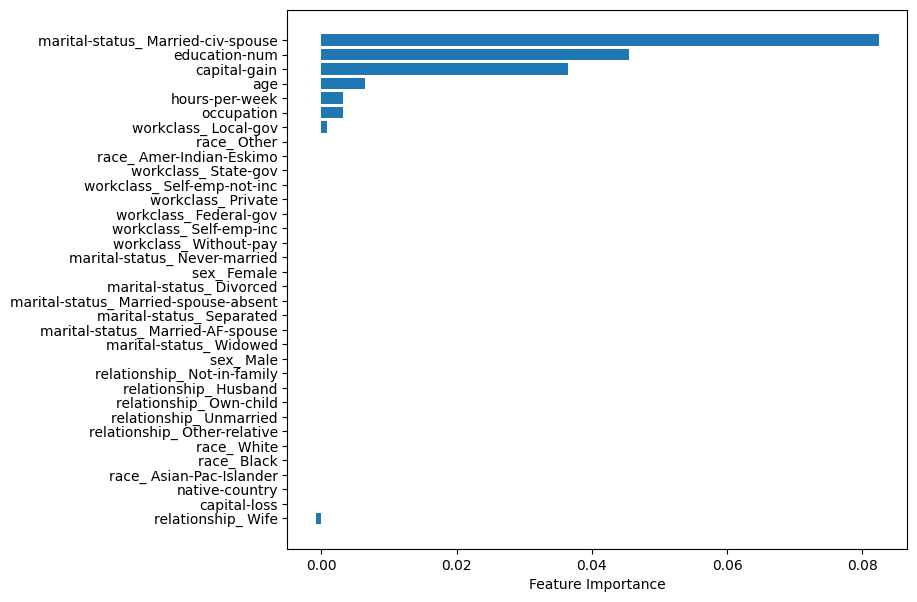

In [ ]:
tree_perm_importance = permutation_importance(tree_cv_model, X_test, y_test)
feature_names = [train.drop(columns=['salary']).columns]
features = np.array(feature_names)
sorted_idx = tree_perm_importance.importances_mean.argsort()
plt.figure(figsize=(8,7))
plt.barh(features[0][sorted_idx], tree_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

Text(0.5, 0, 'Feature Importance')

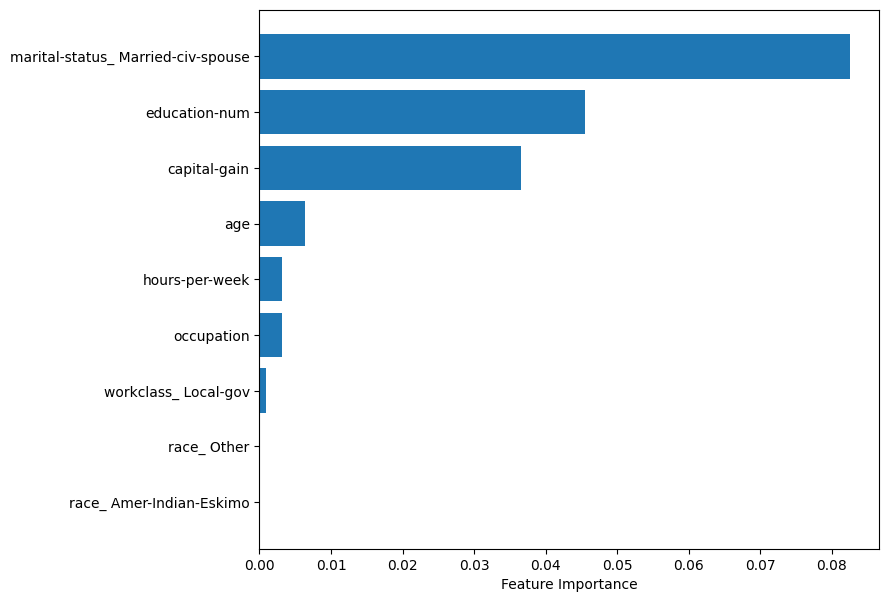

In [ ]:
plt.figure(figsize=(8,7))
plt.barh(features[0][sorted_idx[25:35]], tree_perm_importance.importances_mean[sorted_idx[25:35]])
plt.xlabel("Feature Importance")

# Logistic Regression

In [ ]:
param_grid = dict(penalty = ['l1', 'l2', None],
                  C = np.logspace(-3, 3, 7),
                  solver = ['lbfgs', 'liblinear', 'saga'])
print(param_grid)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'penalty': ['l1', 'l2', None], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['lbfgs', 'liblinear', 'saga']}


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
logistic_result = pd.DataFrame(grid.cv_results_)
logistic_result = logistic_result[-logistic_result['mean_test_score'].isnull()]
logistic_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.076137,0.011899,0.002871,0.000289,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.759845,0.754699,0.756633,0.761194,0.750415,0.756557,0.003834,28
2,1.696105,0.023150,0.003375,0.001646,0.001,l1,saga,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.614896,0.614981,0.617883,0.618988,0.621614,0.617672,0.002540,29
3,0.639518,0.145711,0.005023,0.002648,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.778914,0.771144,0.771006,0.776534,0.767828,0.773085,0.004040,24
4,0.192613,0.013866,0.002360,0.000086,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.790245,0.784135,0.781786,0.788695,0.778331,0.784638,0.004383,13
5,1.458826,0.021554,0.002619,0.000349,0.001,l2,saga,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.614896,0.614981,0.617883,0.618988,0.621614,0.617672,0.002540,29
6,0.451314,0.123208,0.003705,0.001117,0.001,None,lbfgs,"{'C': 0.001, 'penalty': None, 'solver': 'lbfgs'}",0.779467,0.773632,0.772941,0.774876,0.769071,0.773997,0.003353,15
8,1.525622,0.169676,0.002627,0.000331,0.001,None,saga,"{'C': 0.001, 'penalty': None, 'solver': 'saga'}",0.614896,0.614981,0.617883,0.618988,0.621614,0.617672,0.002540,29
10,0.241747,0.013938,0.002247,0.000095,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.813320,0.810531,0.811913,0.811360,0.806523,0.810729,0.002291,7
11,1.870830,0.253571,0.003281,0.001517,0.01,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.614896,0.614981,0.617883,0.618988,0.621614,0.617672,0.002540,29
12,0.370592,0.020785,0.002546,0.000188,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.764405,0.757186,0.768795,0.774461,0.768519,0.766673,0.005722,27


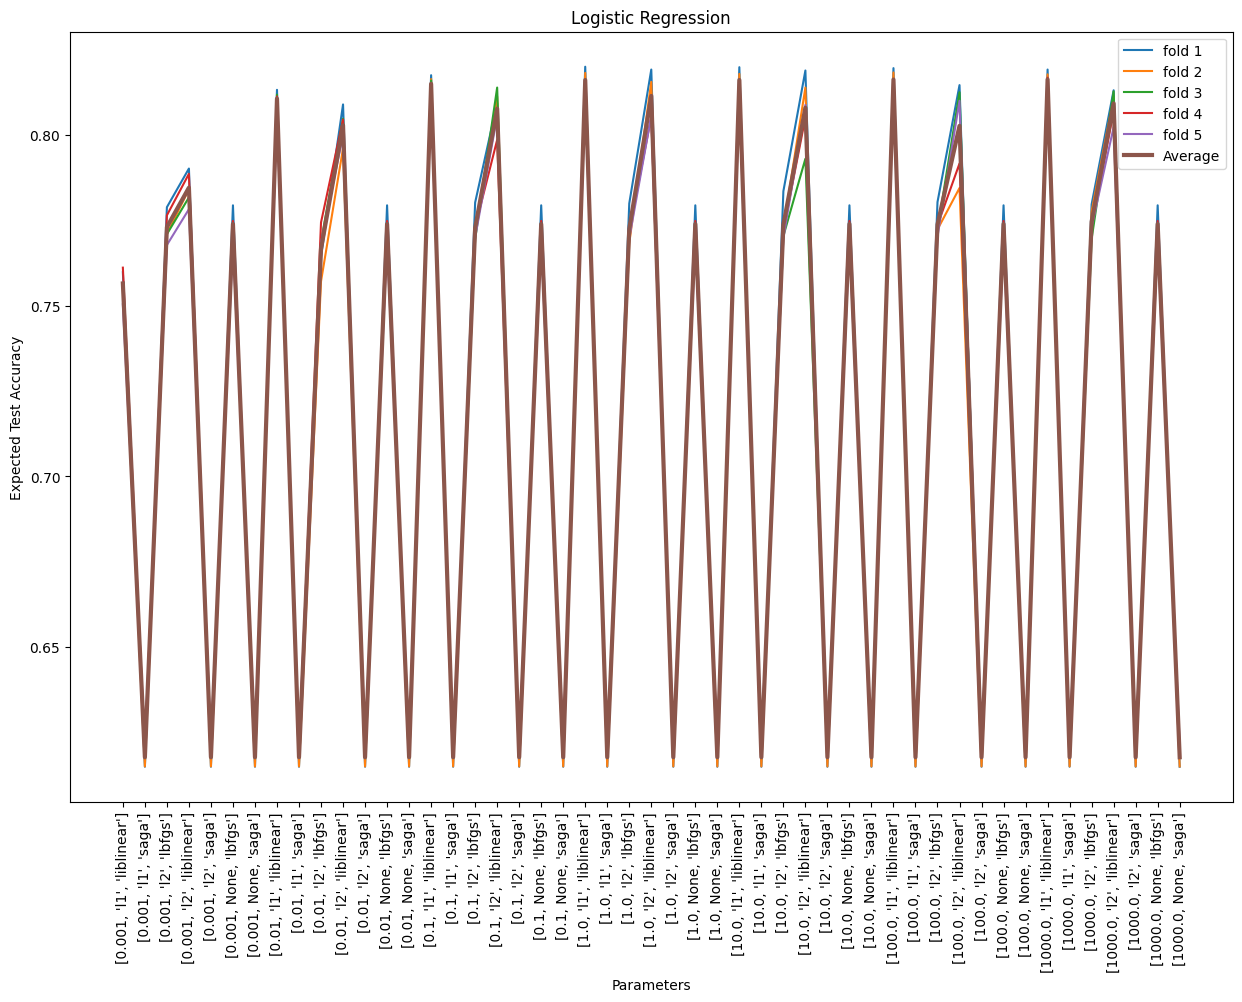

In [ ]:
labels = list()
for i in list(logistic_result['params'].index):
  labels.append(list(logistic_result['params'][i].values()))
x = range(49)
y_1 = logistic_result['split0_test_score']
y_2 = logistic_result['split1_test_score']
y_3 = logistic_result['split2_test_score']
y_4 = logistic_result['split3_test_score']
y_5 = logistic_result['split4_test_score']
y_avg = logistic_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_avg, label = "Average", linewidth=3)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("Logistic Regression")
plt.show()

In [ ]:
print('Best C:', grid.best_estimator_.get_params()['C'])
print('Best Penalty:', grid.best_estimator_.get_params()['penalty'])
print('Best Solver:', grid.best_estimator_.get_params()['solver'])
print('Best mean test error:', grid.best_score_)

Best C: 1000.0
Best Penalty: l1
Best Solver: liblinear
Best mean test error: 0.8163676268069322


In [ ]:
best_logistic_model = LogisticRegression(C=1000, penalty='l1', solver='liblinear')
best_logistic_model.fit(X_train, y_train)

LogisticRegression(C=1000, penalty='l1', solver='liblinear')

Text(0.5, 0, 'Feature Importance')

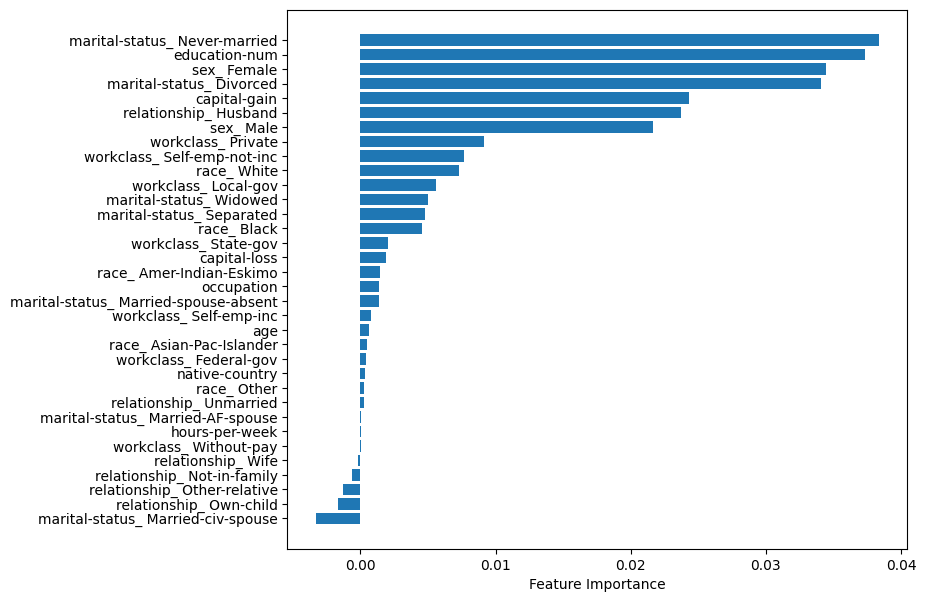

In [ ]:
logistic_perm_importance = permutation_importance(best_logistic_model, X_test, y_test)
sorted_idx = logistic_perm_importance.importances_mean.argsort()
plt.figure(figsize=(8,7))
plt.barh(features[sorted_idx], logistic_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

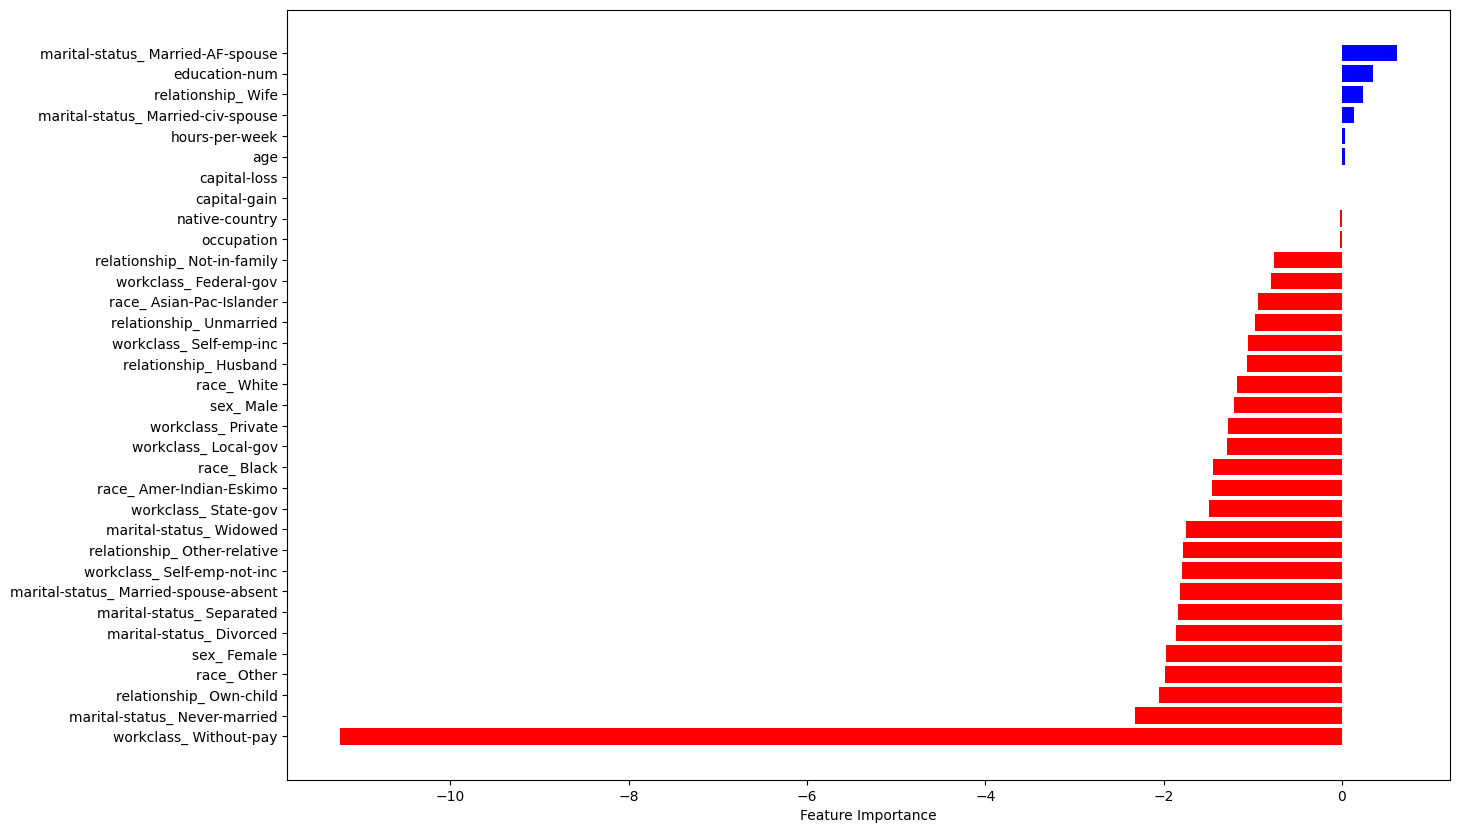

In [ ]:
'''
feature_importance = pd.DataFrame(features, columns = ["feature names"])
feature_importance["importance"] = best_logistic_model.coef_[0]
feature_importance = feature_importance.sort_values(by = ["importance"])
#plt.figure(figsize=(8,7))
colors = ["red" if i < 0 else "blue" for i in feature_importance["importance"]]
plt.barh(feature_importance["feature names"], feature_importance["importance"], color = colors)
plt.xlabel("Feature Importance")
#plt.legend(['< 0', '>= 0'], loc='upper left')
plt.show()
#plt.barh(features, best_logistic_model.coef_[0])
'''

True negative rate(specificity):  0.7701604043067458
True positive rate(sensitivity):  0.854251012145749
F1 score:  0.6673695308381655
Accuracy:  0.7908171722194597


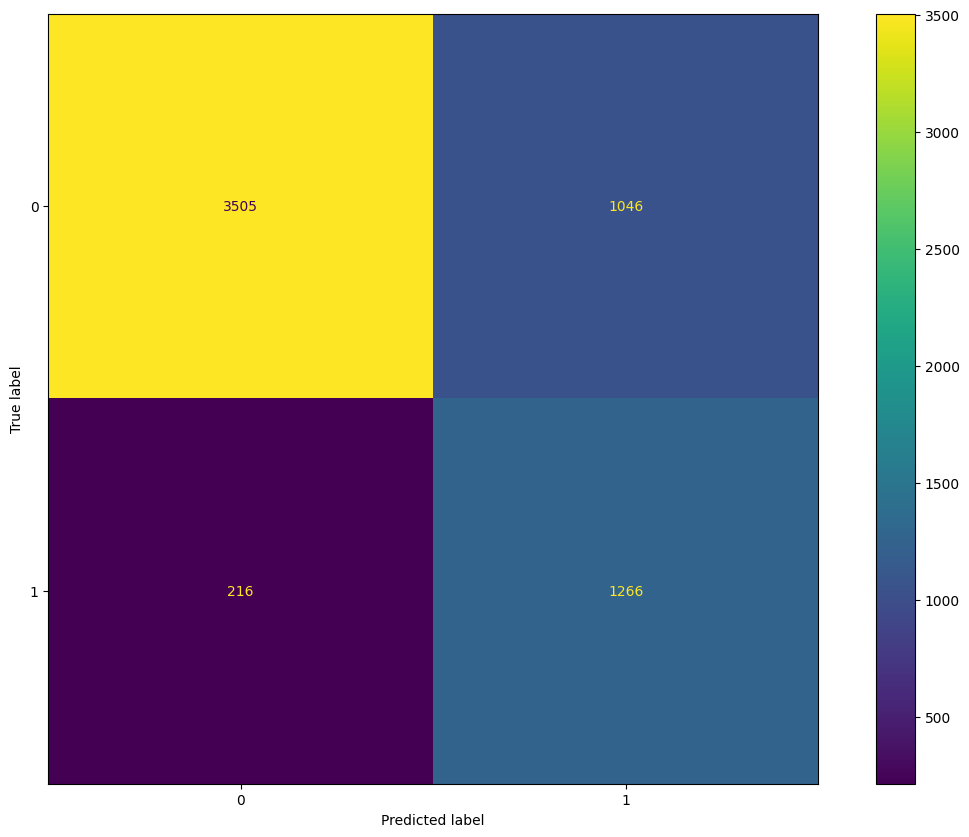

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=best_logistic_model,
    X=X_test,
    y=y_test
)
tn, fp, fn, tp = confusion_matrix(y_test, best_logistic_model.predict(X_test)).ravel()
print('True negative rate(specificity): ', tn / (tn + fp)) #true negative rate(specificity)
print('True positive rate(sensitivity): ', tp / (tp + fn)) #true positive rate(sensitivity)
print('F1 score: ',(2*tp)/(2*tp + fp + fn)) #f1 score
print('Accuracy: ',(tp + tn) / (tn + fp + fn + tp))

In [ ]:
def plot_roc_curve(true_y, y_prob, label, color):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr,label = label, color = color)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [ ]:
roc_knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')
roc_knn.fit(X=orig_X_train, y=orig_y_train)
y_pred_proba_knn = roc_knn.predict_proba(orig_X_test)[:,1]
roc_svm = SVC(C=10, gamma='auto', kernel='rbf', probability = True)
roc_svm.fit(X_train, y_train)
y_pred_proba_svm = roc_svm.predict_proba(X_test)[:,1]

In [ ]:
tree_pipeline = Pipeline([
    ('model', tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=100, min_samples_split=100))
])
tree_pipeline.fit(X_train, y_train)
y_pred_proba_tree = tree_pipeline.predict_proba(X_test)[:,1]

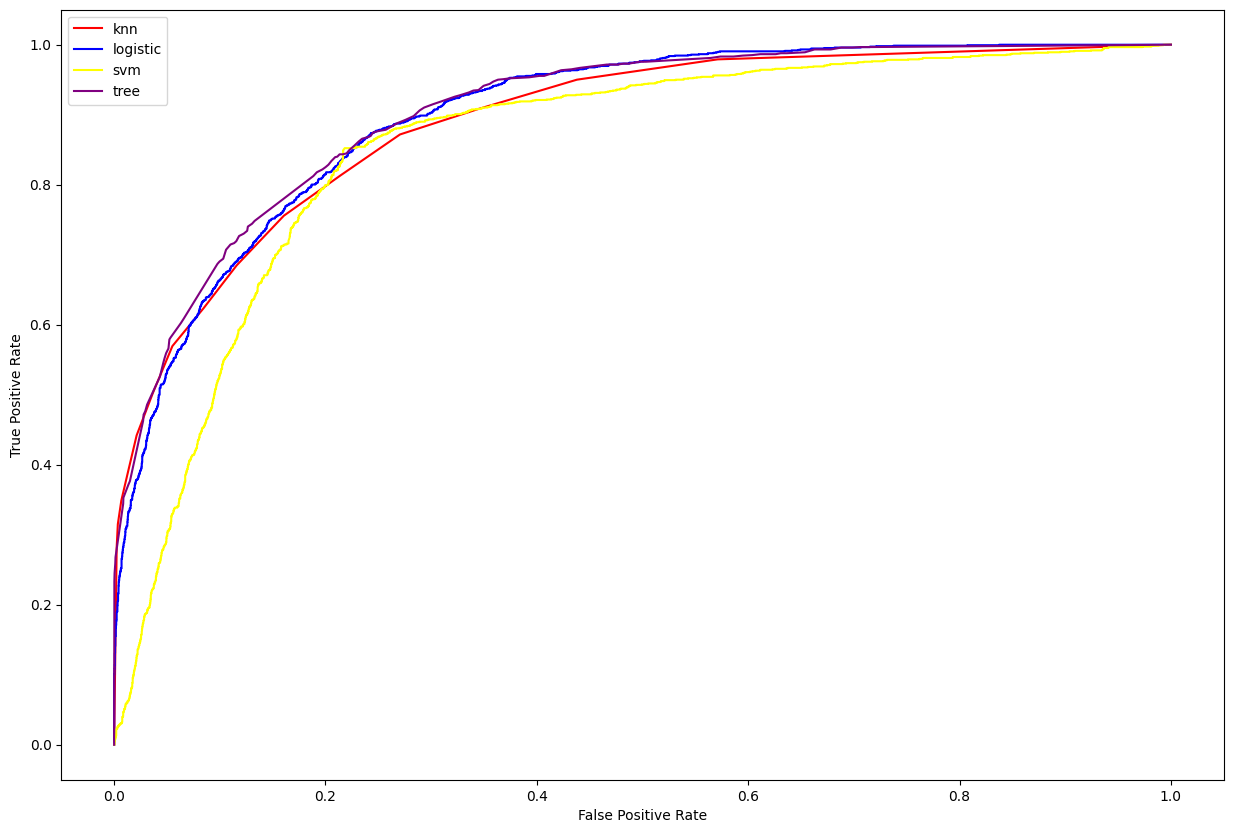

In [ ]:
plot_roc_curve(orig_y_test, y_pred_proba_knn,"knn","red")
plot_roc_curve(y_test, y_pred_proba,"logistic","blue")
plot_roc_curve(y_test, y_pred_proba_svm,"svm","yellow")
plot_roc_curve(y_test, y_pred_proba_tree,"tree","purple")
plt.legend()
plt.show()


Logistic Regression AUC score: 0.8122057082262474


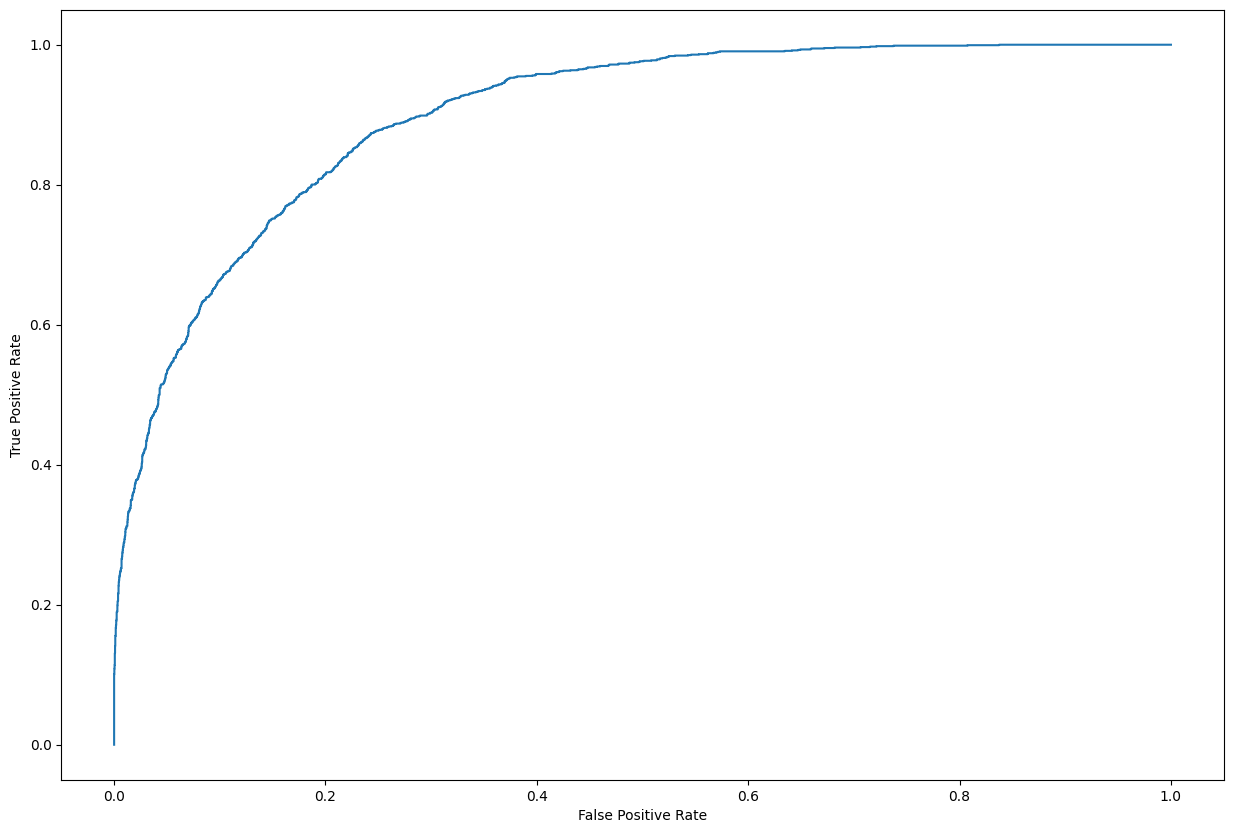

In [ ]:
y_pred_proba = best_logistic_model.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_pred_proba)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, best_logistic_model.predict(X_test))}')

# KNN

In [ ]:
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  KNeighborsClassifier())
])
knn_param_grid = [
  {'model__n_neighbors': range(1, 50),
  'model__weights': ['uniform', 'distance']}
 ]
cv = KFold(
    n_splits=5,  # number of folds
    shuffle=True # protects against data being ordered, e.g., all successes first
)

knn_cv_model = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_param_grid,
    cv=cv
)


In [ ]:
knn_cv_model.fit(X=orig_X_train, y=orig_y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid=[{'model__n_neighbors': range(1, 50),
                          'model__weights': ['uniform', 'distance']}])

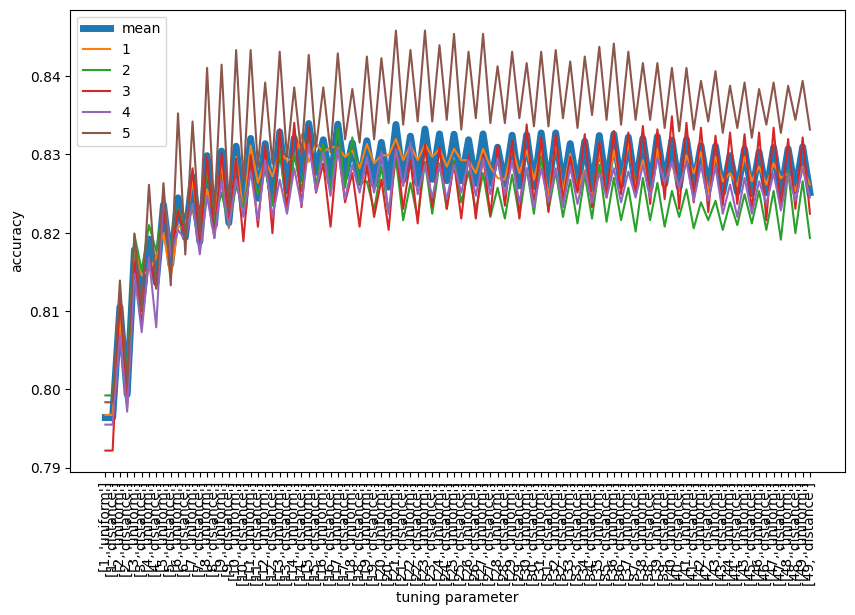

In [ ]:
knn_mean_sc = knn_cv_model.cv_results_['mean_test_score']

figure(figsize=(10,6))
x = range(len(knn_mean_sc))
x_axis = [list(d.values()) for d in knn_cv_model.cv_results_['params']]
plt.xticks(x, x_axis,rotation = 90)
plt.plot(x, knn_mean_sc,label = "mean",linewidth = 5)
plt.plot(x, knn_cv_model.cv_results_['split0_test_score'],label = "1")
plt.plot(x, knn_cv_model.cv_results_['split1_test_score'],label = "2")
plt.plot(x, knn_cv_model.cv_results_['split2_test_score'],label = "3")
plt.plot(x, knn_cv_model.cv_results_['split3_test_score'],label = "4")
plt.plot(x, knn_cv_model.cv_results_['split4_test_score'],label = "5")
plt.xlabel('tuning parameter')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
knn_cv_model.best_params_

{'model__n_neighbors': 15, 'model__weights': 'uniform'}

In [ ]:
# test error
1.0 - knn_cv_model.score(X=orig_X_test, y=orig_y_test)

0.16227415879330354

True negative rate(specificity):  0.9101296418369589
True positive rate(sensitivity):  0.6153846153846154
F1 score:  0.6507313592579379
Accuracy:  0.8377258412066965


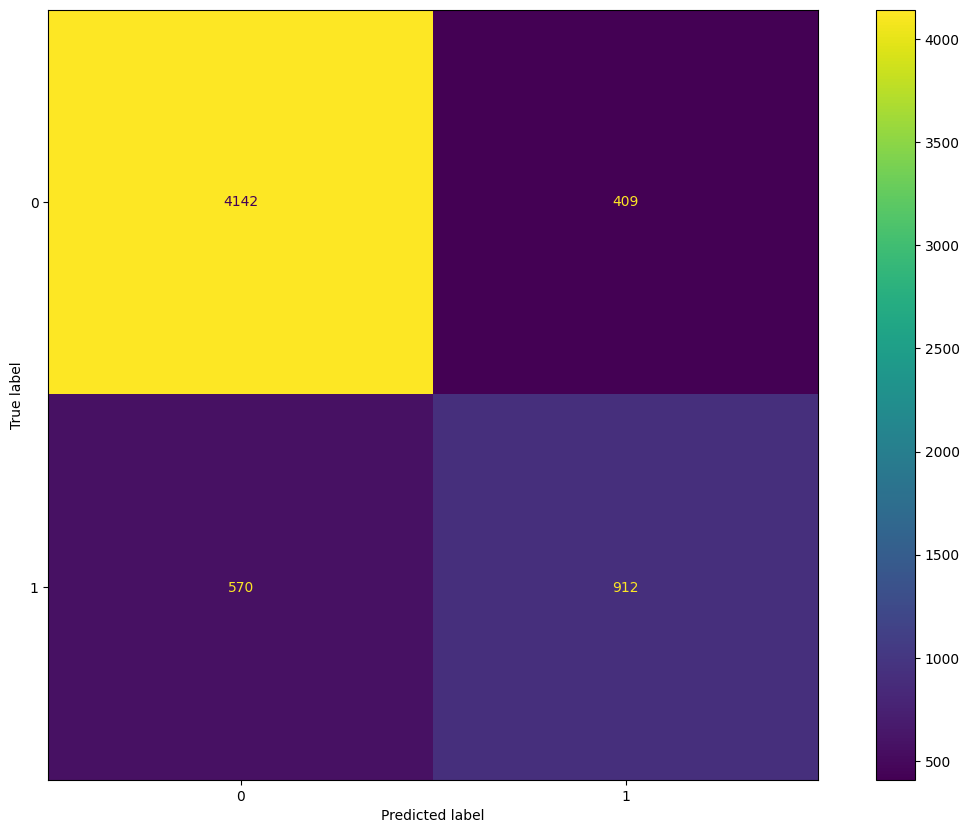

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=knn_cv_model,
    X=orig_X_test,
    y=orig_y_test
)
tn, fp, fn, tp = confusion_matrix(orig_y_test, knn_cv_model.predict(orig_X_test)).ravel()
print('True negative rate(specificity): ', tn / (tn + fp)) #true negative rate(specificity)
print('True positive rate(sensitivity): ', tp / (tp + fn)) #true positive rate(sensitivity)
print('F1 score: ',(2*tp)/(2*tp + fp + fn)) #f1 score
print('Accuracy: ',(tp + tn) / (tn + fp + fn + tp))

# NN

In [ ]:
class CropDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, csv_file):
        """Initializes instance of class StudentsPerformanceDataset.

        Args:
            csv_file (str): Path to the csv file with the students data.

        """
        df = pd.read_csv(csv_file)
        df = df.drop(columns=['education', 'fnlwgt'])

        # Grouping variable names
        self.categorical = ['workclass','marital-status','relationship', 'race','sex']
        self.target = 'salary'

        self.label_encoder = ce.OrdinalEncoder(cols='salary', return_df=True)
        self.students_frame = self.label_encoder.fit_transform(df)
        self.students_frame['salary'] = self.students_frame['salary']-1
        self.label_encoder = ce.OrdinalEncoder(cols='occupation', return_df=True)
        self.students_frame = self.label_encoder.fit_transform(self.students_frame)
        self.label_encoder = ce.OrdinalEncoder(cols='native-country', return_df=True)
        self.students_frame = self.label_encoder.fit_transform(self.students_frame)
        self.students_frame = pd.get_dummies(self.students_frame, prefix=self.categorical)
        print(self.students_frame)
        # Save target and predictors
        self.X = self.students_frame.drop(self.target, axis=1)
        self.y = self.students_frame[self.target]
        print(self.X)
    def __len__(self):
        return len(self.students_frame)

    def __getitem__(self, idx):
    #    # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        #print(idx)
        return [self.X.iloc[idx].values, self.y[idx]]

In [ ]:
class Net(nn.Module):

    def __init__(self, D_in, H=32, D_out=1):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x.squeeze()

In [ ]:
def train(csv_file, n_epochs=100):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    dataset = CropDataset(csv_file)
    #dataset = df

    # Split into training and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size])

    # Dataloaders
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    D_in, H = 36, 24
    net = Net(D_in, H).to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), weight_decay=0.0001)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []
    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #print(inputs)
            #print(labels)
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

    # Comparing training to test
    dataiter = iter(testloader)
    inputs, labels = next(dataiter)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs.float())
    print("Root mean squared error")
    print("Training:", np.sqrt(loss_per_batch[-1]))
    print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

    # Plot training loss curve
    plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

       age  education-num  occupation  capital-gain  capital-loss  \
0       39             13           1          2174             0   
1       50             13           2             0             0   
2       38              9           3             0             0   
3       53              7           3             0             0   
4       28             13           4             0             0   
...    ...            ...         ...           ...           ...   
32556   27             12          11             0             0   
32557   40              9          10             0             0   
32558   58              9           1             0             0   
32559   22              9           1             0             0   
32560   52              9           2         15024             0   

       hours-per-week  native-country  salary  workclass_ ?  \
0                  40               1       0             0   
1                  13               1       0

<ipython-input-6-cb11566b0ca7>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Root mean squared error
Training: 0.3568878516093303
Test 0.38429308


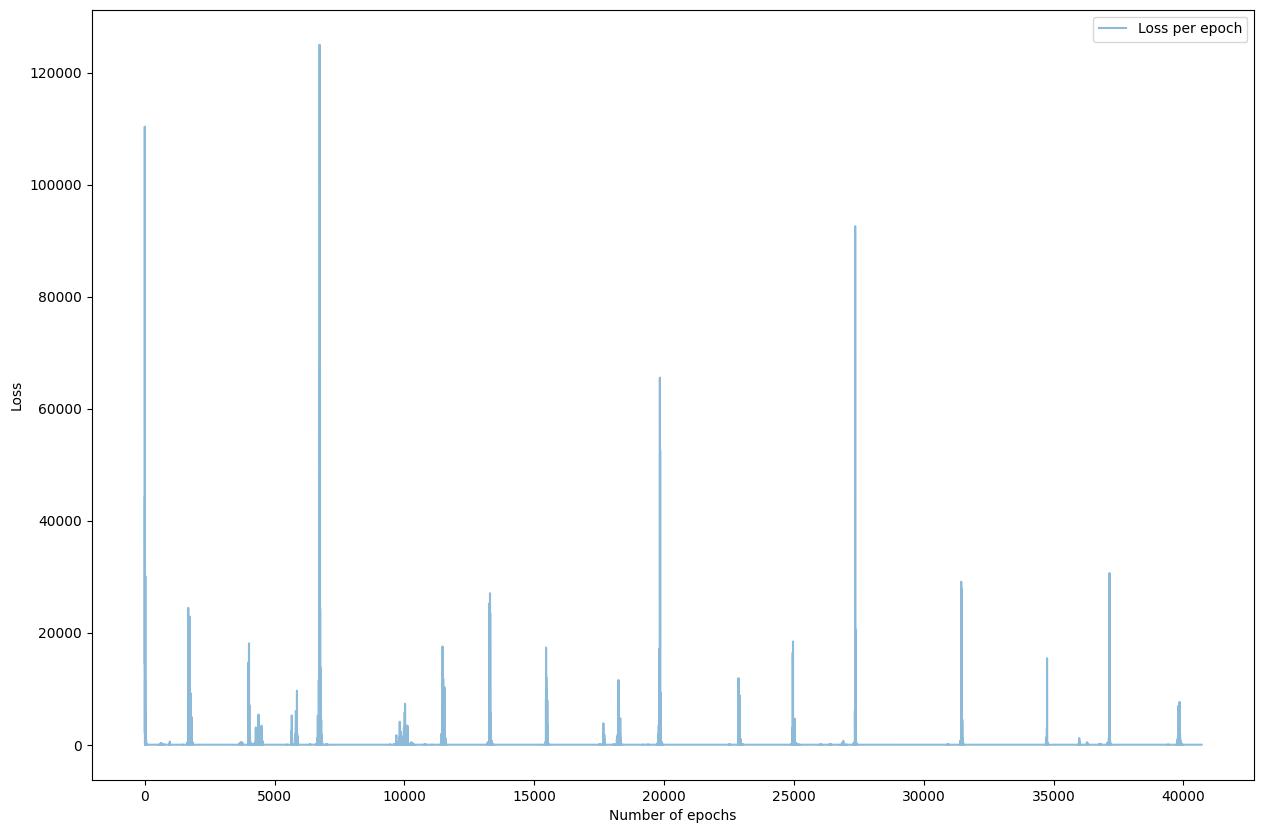

In [ ]:
import argparse
#csv_file = os.path.join(sys.path[0], "StudentsPerformance.csv")
csv_file = io.BytesIO(uploaded['salary.csv'])

#Parsing arguments
parser = argparse.ArgumentParser()
parser.add_argument("--file", "-f", nargs="?", const=csv_file, default=csv_file,
                        help="Dataset file used for training")
parser.add_argument("--epochs", "-e", type=int, nargs="?", default=100, help="Number of epochs to train")
args = parser.parse_args()

# Call the main function of the script
train(csv_file)

In [ ]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])